# Essentially a copy of [this Colab NB](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX?usp=sharing) from Chris McCormick and Nick Ryan.

In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# <span style="color:#FF8800"> (Most) Installs

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 7.3MB/s 
     |████████████████████████████████| 890kB 30.0MB/s 
     |████████████████████████████████| 3.0MB 41.2MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=27c2d0abd6f99501aa81cc94c41fe29112e8f56d608622b0ce1caa9cb7eae9ad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#standard library imports
import datetime
import itertools
import os
import random
import time
import warnings

#3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

#local app & library specific imports
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_fscore_support #classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup

# <span style="color:#FF8800"> Setup & global vars

In [4]:
# alert for cells
from IPython.display import Audio

alert = Audio(np.sin(np.linspace(0, 3000, 20000)), rate=20000, autoplay=True)

In [5]:
%cd drive/'My Drive'/propaganda_bert/

/content/drive/My Drive/propaganda_bert


In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv(
    "datasets/train_data.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

Number of training sentences: 15,928



In [8]:
train_df.sample(3)

,label,label_binary,text
13655,No_Propaganda,No_Propaganda,of 06:30 EDT - Details)\nWas Hunt referring to...
3516,No_Propaganda,No_Propaganda,".\nExpelled former student Nikolas Cruz, 19, h..."
12514,No_Propaganda,No_Propaganda,"norms, or rules – 289 of them!\n– that all com..."


In [10]:
# Global vars - vars in ALL_CAPS can be adjusted to enable experiments

#Dataset vars
THESE_LABELS = "label_binary" # use 'label' for multi-class classification & 'label_binary' for binary
NUM_LABELS = train_df[THESE_LABELS].nunique()
print(f"NUM_LABELS: {NUM_LABELS}")

#BERT/Training vars
MODEL = "distilbert-base-cased"
EPOCHS = 3 # Good starting range is 2 to 4
LEARNING_RATE = 5e-5 # Good starting range is 2e-5 to 5e-5
BATCH_SIZE = 32 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

NUM_LABELS: 2


In [11]:
sentences = train_df.text.values

le = LabelEncoder()
labels = le.fit_transform(train_df[THESE_LABELS]) # encode labels as ints

counter = 0
for entry in le.classes_:
  print(f"{counter}: {entry}")
  counter += 1

train_df[THESE_LABELS+"_encoded"] = labels # add col to train_df with ints for labels

0: No_Propaganda
1: Propaganda


In [12]:
train_df.sample(3)

,label,label_binary,text,label_binary_encoded
1715,No_Propaganda,No_Propaganda,assessment.\nThe president of the CRIF umbrell...,0
3601,"Bandwagon,Reductio_ad_hitlerum",Propaganda,a good strategy was to blame the assassination...,1
15827,No_Propaganda,No_Propaganda,"In the memo, Congress’s top law enforcement of...",0


# Get tokenizer & tokenize training data

In [13]:
print('Loading tokenizer...')
if MODEL == "distilbert-base-cased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case = True)

elif MODEL == "distilbert-base-uncased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)

elif MODEL == "bert-base-cased":

  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

elif MODEL == "roberta-base":

  from transformers import RobertaTokenizer
  tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

else:
  raise ValueError('Unknown model specified. Check MODEL var.')

Loading tokenizer...


In [14]:
random_sample = random.randint(0,train_df.shape[0])

# Print the original sentence.
print(' Original: ', sentences[random_sample])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[random_sample]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[random_sample])))

#Print the associated label
print("Label: ", labels[random_sample])

 Original:  gang-raped
Tokenized:  ['gang', '-', 'raped']
Token IDs:  [6939, 118, 16567]
Label:  1


In [15]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

if max_len <= 512:
  print('Max sentence length: ', max_len) #max sentence len for BERT is 512
else:
  warnings.warn("WARNING: max_len exceeds max token length for BERT.")

Max sentence length:  204


In [16]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    #`encode_plus` will:
    #(1) Tokenize the sentence.
    #(2) Prepend the `[CLS]` token to the start.
    #(3) Append the `[SEP]` token to the end.
    #(4) Map tokens to their IDs.
    #(5) Pad or truncate the sentence to `max_length`
    #(6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,                         #Sentence to encode.
        add_special_tokens=True,    #Add '[CLS]' and '[SEP]'
        max_length=max_len,         #Pad & truncate all sentences.
        truncation=True,
        pad_to_max_length=True,
        return_attention_mask=True, # Construct attn. masks.
        return_tensors='pt',        # Return pytorch tensors.
    )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence as a list of IDs.
print('Original: ', sentences[random_sample])
print('Token IDs:', input_ids[random_sample])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  gang-raped
Token IDs: tensor([  101,  6939,   118, 16567,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   

In [17]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

14,335 training samples
1,593 validation samples


In [18]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

# Configure model

In [19]:
if MODEL == "distilbert-base-cased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-cased",
      num_labels = NUM_LABELS,
      output_attentions = False,
      output_hidden_states = False,
)
  
elif MODEL == "distilbert-base-uncased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-uncased",
      num_labels = NUM_LABELS,
      output_attentions = False,
      output_hidden_states = False,
)
  
elif MODEL == "bert-base-cased":

  from transformers import BertForSequenceClassification

  model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = NUM_LABELS,
    output_attentions = False,
    output_hidden_states = False,
)
  
elif MODEL == "roberta-base":

  from transformers import RobertaForSequenceClassification

  model = RobertaForSequenceClassification.from_pretrained('roberta-base')

else:
  raise ValueError('Unknown model specified. Check MODEL var.')

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
optimizer = AdamW(
    model.parameters(),
    lr = LEARNING_RATE,
    eps = 1e-8 #small weight to add to avoid zero weights
)

# Training & validation

In [21]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
def val_metrics(preds, labels):
  """
  Calculates a variety of metrics during validation steps in training.

  Args:
    preds - an array of prediction scores, one for each class being assessed. Will be an array of shape (n_samples,1).
    labels - an array of the true labels for a given set of validation samples. Should also be an array of shape (n_samples, n_classes). 

  Returns:
    result - a dictionary of metrics and their values.
  """
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  precision, recall, f1_micro, support = precision_recall_fscore_support(
      y_true = labels_flat, 
      y_pred = preds_flat, 
      zero_division = 0, 
      average = "micro"
  ) #using average = micro is consistent with LR & other models & SemEval metrics

  f1_macro = f1_score(y_true = labels_flat, y_pred = preds_flat, average = "macro", zero_division = 0)

  result = {
      "Precision": precision,
      "Recall": recall,
      "F1_micro": f1_micro,
      "F1_macro": f1_macro
  }

  return result

In [24]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
val_predictions, val_true_labels = [], []
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    ##############
    ## TRAINING ##
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be misled--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. Here it returns the loss and the logits.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    ################    
    ## VALIDATION ##

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_f1_micro = 0
    total_eval_f1_macro = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        val_predictions.append(logits)
        val_true_labels.append(label_ids)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

        # Calculate other metrics and accumulate over all batches
        these_val_metrics = val_metrics(logits, label_ids)
        total_eval_precision += these_val_metrics["Precision"]
        total_eval_recall += these_val_metrics["Recall"]
        total_eval_f1_micro += these_val_metrics["F1_micro"]
        total_eval_f1_macro += these_val_metrics["F1_macro"]        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Calculate other metrics
    avg_eval_precision = total_eval_precision/len(validation_dataloader)
    avg_eval_recall = total_eval_recall/len(validation_dataloader)
    avg_eval_f1_micro = total_eval_f1_micro/len(validation_dataloader)
    avg_eval_f1_macro = total_eval_f1_macro/len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Avg. Accur.': avg_val_accuracy,
            'Avg. Precision': avg_eval_precision,
            'Avg. Recall': avg_eval_recall,
            'Avg. F1_micro': avg_eval_f1_micro,
            'Avg. F1_macro': avg_eval_f1_macro,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

alert


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    448.    Elapsed: 0:00:21.
  Batch    80  of    448.    Elapsed: 0:00:42.
  Batch   120  of    448.    Elapsed: 0:01:04.
  Batch   160  of    448.    Elapsed: 0:01:28.
  Batch   200  of    448.    Elapsed: 0:01:52.
  Batch   240  of    448.    Elapsed: 0:02:16.
  Batch   280  of    448.    Elapsed: 0:02:40.
  Batch   320  of    448.    Elapsed: 0:03:03.
  Batch   360  of    448.    Elapsed: 0:03:28.
  Batch   400  of    448.    Elapsed: 0:03:52.
  Batch   440  of    448.    Elapsed: 0:04:15.

  Average training loss: 0.12
  Training epoch took: 0:04:20

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:11

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    448.    Elapsed: 0:00:24.
  Batch    80  of    448.    Elapsed: 0:00:48.
  Batch   120  of    448.    Elapsed: 0:01:12.
  Batch   160  of    448.    Elapsed: 0:01:36.
  Batch   200  of    448.    Elapsed: 0:02:00.
  Batch  

# Assess training & validation performance

In [26]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Avg. Accur.,Avg. Precision,Avg. Recall,Avg. F1_micro,Avg. F1_macro,Training Time,Validation Time
epoch,,,,,,,,,
1,1.23e-01,0.08,0.97,0.97,0.97,0.97,0.97,0:04:20,0:00:11
2,2.80e-02,0.08,0.98,0.98,0.98,0.98,0.98,0:04:29,0:00:11
3,5.89e-03,0.08,0.98,0.98,0.98,0.98,0.98,0:04:28,0:00:11


In [27]:
df_stats.describe().loc["mean",["Avg. Accur.","Avg. Precision", "Avg. Recall", "Avg. F1_micro", "Avg. F1_macro"]]

Avg. Accur.       0.98
Avg. Precision    0.98
Avg. Recall       0.98
Avg. F1_micro     0.98
Avg. F1_macro     0.98
Name: mean, dtype: float64

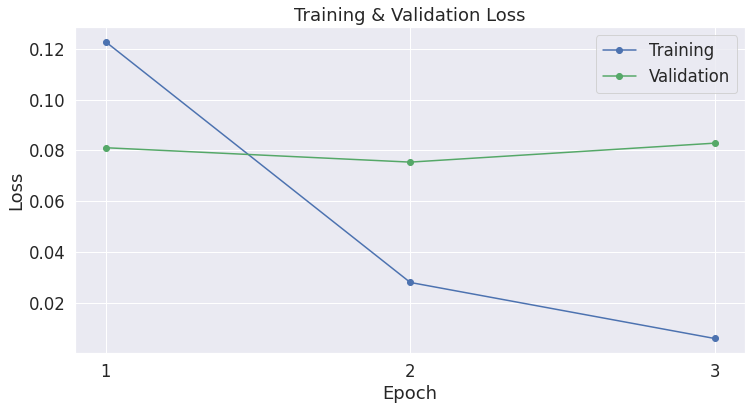

In [28]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,EPOCHS+1))

plt.show()

# Save model

In [35]:
# output_dir = './binary_model/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.config.id2label = {i: le.classes_[i] for i in range(len(le.classes_))}
# model_to_save.config.label2id = {le.classes_[i]:i for i in range(len(le.classes_))}
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# END